**базовые модели ML**

Евгений Борисов <esborisov@sevsu.ru>

решение задачи бинарной классификации

----

In [1]:
import numpy as np
import numpy.random as rng
# import pandas as pd
# from tqdm import tqdm
# from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
# tqdm.pandas ()
# pd.options.display.float_format = '{:,.2f}'.format

---

In [3]:
import sys 
import logging

logging.basicConfig(
    format=u'[%(levelname)-8s] %(asctime)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    level=logging.DEBUG,
    stream=sys.stdout,
    )

In [4]:
# показывать выдачу всех строк ячейки
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## генерируем датасет

In [5]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

X,target = make_blobs( n_samples=10_000, n_features=2, centers=2, cluster_std=[1.7,1.8] )
# X,target = make_blobs( n_samples=100_000, n_features=1024, centers=2, cluster_std=[1.7,1.8] )

# докидываем свободный член для линейных моделей
X = np.hstack([X,np.ones((X.shape[0],1))])

print( X.shape,target.shape )

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.33)
X_train, X_val, target_train, target_val = train_test_split(X_train, target_train, test_size=0.33)

del X,target

(10000, 3) (10000,)


In [6]:
logging.getLogger().setLevel(logging.CRITICAL) 
InteractiveShell.ast_node_interactivity = 'last_expr'

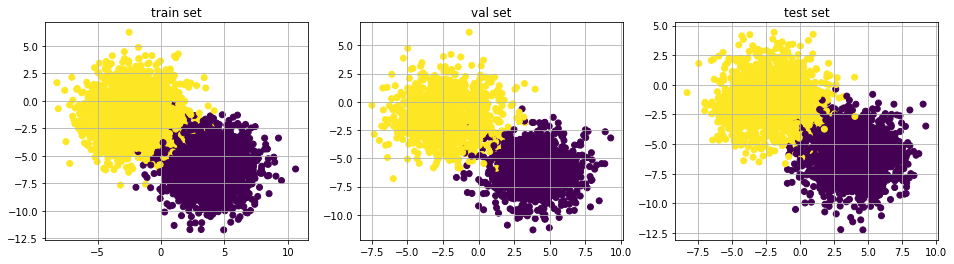

In [7]:
fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(16,4))
ax0.scatter(X_train[:,0],X_train[:,1],c=target_train)
ax0.grid()
ax0.set_title('train set')

ax1.scatter(X_val[:,0],X_val[:,1],c=target_val)
ax1.set_title('val set')
ax1.grid()

ax2.scatter(X_test[:,0],X_test[:,1],c=target_test)
ax2.set_title('test set')
ax2.grid()

In [8]:
logging.getLogger().setLevel(logging.DEBUG) 
InteractiveShell.ast_node_interactivity = 'all'

## LogisticRegression + CCE + GD

100%|██████████| 25/25 [00:00<00:00, 313.01it/s, loss=0.262, lr=0.1]

(4489, 1) (2211, 1) (3300, 1)
[[0]
 [1]
 [0]]
(3, 1)


score threshold to predict is 0.24444513864692674
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1662
           1       0.98      0.98      0.98      1638

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



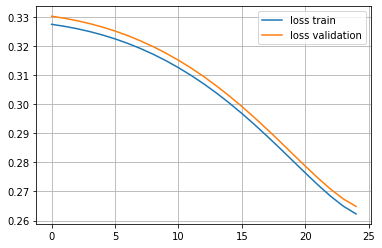

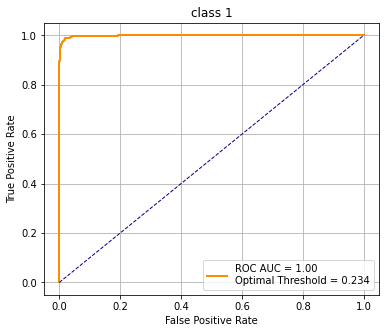

In [9]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis] for t in [ target_train, target_val, target_test ] ]
# выход = метка класса

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP( # логистическая регрессия 1./(1.+np.exp(-x.dot(w)) )
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.cce import CCE # ф-ция потери - кросс-энтропия
loss_train = CCE(model)
loss_val = CCE(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
    breaker_val=[GrowthBreaking(),]

).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))

## LinearClassifier + Hinge + GD

  8%|▊         | 2/25 [00:00<00:00, 98.93it/s, loss=0.968, lr=0.1]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)
[INFO    ] 2021-10-04 11:41:56 | GrowthBreaking: significant increase in the loss function has been detected


score threshold to predict is 0.09091197082402248
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1662
           1       0.85      0.85      0.85      1638

    accuracy                           0.85      3300
   macro avg       0.85      0.85      0.85      3300
weighted avg       0.85      0.85      0.85      3300



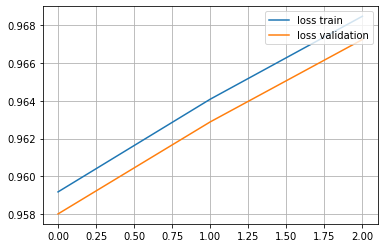

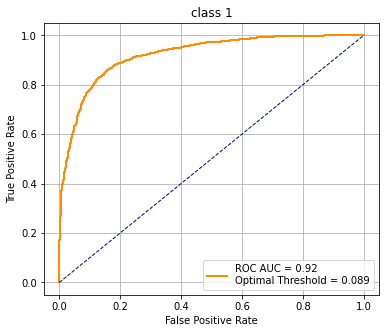

In [10]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import LinearClassifier
from lib.initiator.linear import NormalInitiatorLinearModel

model = LinearClassifier(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.binary.hinge import HingeLoss
loss_train = HingeLoss(model)
loss_val = HingeLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))

## SPL_BPS + Hinge + GD

  8%|▊         | 2/25 [00:00<00:00, 116.65it/s, loss=0.793, lr=0.1]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)
[INFO    ] 2021-10-04 11:42:01 | GrowthBreaking: significant increase in the loss function has been detected


score threshold to predict is -0.11745327276464926
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1662
           1       0.97      0.99      0.98      1638

    accuracy                           0.98      3300
   macro avg       0.98      0.98      0.98      3300
weighted avg       0.98      0.98      0.98      3300



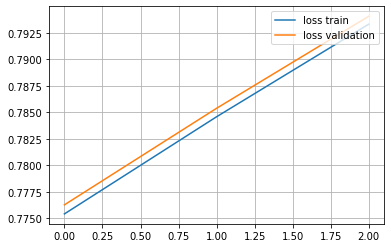

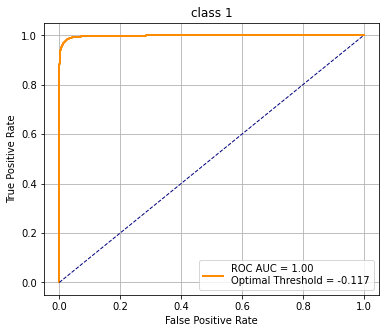

In [11]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.binary.hinge import HingeLoss
loss_train = HingeLoss(model)
loss_val = HingeLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))

## SPL_BPS + Logistic + GD

100%|██████████| 25/25 [00:00<00:00, 347.30it/s, loss=0.504, lr=0.1]

(4489, 1) (2211, 1) (3300, 1)
[[-1]
 [ 1]
 [-1]]
(3, 1)


score threshold to predict is -0.8193644950802143
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1662
           1       0.90      0.93      0.91      1638

    accuracy                           0.91      3300
   macro avg       0.91      0.91      0.91      3300
weighted avg       0.91      0.91      0.91      3300



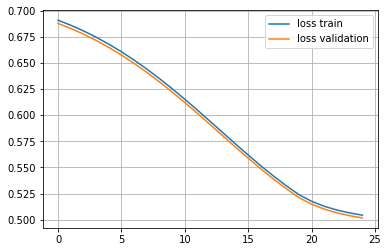

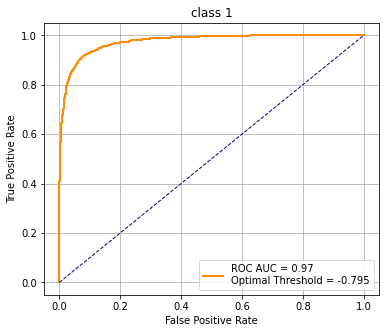

In [12]:
# преобразуем список меток к размерности выхода модели
y_train, y_val, y_test = [ t[:,np.newaxis]*2-1 for t in [ target_train, target_val, target_test ] ]
# выход = метка класса {-1,1}

print(y_train.shape,y_val.shape,y_test.shape)

print(y_train[:3,:])

from lib.model.linear import SLP_BPS
from lib.initiator.linear import NormalInitiatorLinearModel

model = SLP_BPS(
    initiator=NormalInitiatorLinearModel(
        input_size=X_train.shape[1],
        output_size=1,
    )
)

print(model.weight.shape)

from lib.loss.binary.logistic import LogisticLoss
loss_train = LogisticLoss(model)
loss_val = LogisticLoss(model)

from lib.optimizer.gd import GD # метод  оптимизации стохастический градиентный спуск 
from lib.optimizer.lrate import ConstLRA # скорость обучения - константная
from lib.optimizer.breaker import GrowthBreaking # прерывание при росте ф-ции потери

model = GD(
    loss=loss_train,
    loss_val=loss_val,
    lra=ConstLRA(.1),
    breaker_val=[GrowthBreaking(),]
).fit(
    data_train=[X_train,y_train],
    data_val=[X_val,y_val],
    n_epoch=25,
)

from lib.estimator.loss import LossPlot

LossPlot( loss_train=loss_train, loss_val=loss_val, ).plot()

# target_train

from lib.estimator.classifier import BinnaryClassifierScoreThreshold
model = BinnaryClassifierScoreThreshold(model).fit(X_train,target_train[:,np.newaxis])
# model.score_threshold

from lib.estimator.classifier import ClassifierEstimator # оценка классификатора
ClassifierEstimator(model).estimate(X_test,target_test,figsize=(6,5))

In [ ]:
# o = model.score(X_train)
# p = model._partial(X_train)

# margin = y_train -o
# dmargin = y_train[:,np.newaxis] - p
# sigma = .95

# d = 1. + np.exp( sigma * margin )[:,np.newaxis]
# # d.shape

# g = np.where( d!=0, (-sigma/d)*dmargin, 0. )
# g = g.sum(axis=0)/len(g)

# g.shape

---

In [ ]:
# # plt.plot( np.cosh(range(-10,10)))
# # plt.plot( np.tanh(range(-10,10)))
# # np.sech(range(-10,10))
# x = np.linspace(-.1,.1,1000)
# # plt.plot( x, (np.exp(x) + np.exp(-x) )/2. )
# plt.plot( x, np.cosh(x) )
# plt.grid()

In [ ]:
# n,i=4,3
# t = rng.randint(low=0,high=m,size=(n,1))*2-1
# x = rng.normal(size=(n,i))
# w = rng.normal(size=(i,1))
# o = x.dot(w)

# # x.shape,w.shape,o.shape,t.shape

# def hinge(t,o):
#     l = 1.-t*o
#     return np.where( l>0., l, .0 )


# x.shape,t.shape

# # np.where( t*o<1, -t*x, 0, )

# def d_hinge(t,x,w):
#     o = x.dot(w)
#     g = np.where( t*o<1, -t*x, 0, )
#     return (g.sum(axis=0)/len(g))[:,np.newaxis]

# np.hstack([
# t,o, hinge(t,o),
# ])

# w.shape
# d_hinge(t,x,w) 


In [ ]:
# def hinge(t,o):
#     l = 1.-t*o
#     return np.where( l>0., l, .0 )

# # def d_hinge(t,x,o):
# #     l = 1.-t*o
# #     return np.where( l>0., l, .0 )


# t = rng.randint(low=0,high=m,size=(n,))*2-1
# o = rng.normal(size=(n,))

# np.hstack([
# t,o, hinge(t,o)  
# ])

In [ ]:
# def hinge(t,o):
#     l = 1.-t*o
#     return np.where( l>0., l, .0 )

# np.max(0.,x)
# o = 1.-x
# np.where( o>0., o , .0 )

In [ ]:
# rng.randint?
# np.eye(m+1)

In [ ]:
# 1.-x